In [1]:
from Segnet_transfer import SegNet   
import keras
from Scripts import Random_walker,EclipseGenerator
from keras.models import Sequential
from keras.layers import Conv2D,ReLU,BatchNormalization,LeakyReLU,Reshape
from keras import models, layers
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from imageio import imread
from inputs_object import get_filename_list
import pickle as pkl
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


## Usage
In order to run this notebook you need to have the files from https://github.com/toimcio/SegNet-tensorflow in the same directory than this notebook. Moreover, you need the 'vgg16.npy' file also in the running directory, which can be found in this link: https://mega.nz/#!YU1FWJrA!O1ywiCS2IiOlUCtCpI6HTJOMrneN-Qdv3ywQP5poecM. Finally, you need to download the saved model from https://drive.google.com/drive/folders/1tD-4FsN6s8c45R81bjqIG_f5VCS1j-Db and put the downloaded folder also in the running directory. Doing so the notebook should run without any problem. If there is any problem, make sure that the file and directory paths fit the ones from the 'config.json' file.


### One hot function

In [2]:
#2 class 
num_classes=2
def one_hot(y):
    
    length,w,h,c=y.shape
    output=[]

    for i in range(length):
        x=y[i].reshape([1,-1]).astype(int)
        tmp=np.zeros([ num_classes,w*h])
        tmp[0]=1-x
        tmp[1]=x
        tmp=tmp.T
        output.append(tmp)
    
    return np.array(output)

***Loading data***

In [3]:
config_file='config2.json'
seg=SegNet(config_file)    
logits,labels, images=seg.transfer_output(dataset_type = "TRAIN",rotation=[0])
logits=np.array([m[0][0] for m in logits[0]])
labels=np.array([m[0] for m in labels[0]])
images=np.array([m[0] for m in images[0]])
train_images=images
x_train,y_train=logits,one_hot(labels/255)

seg=SegNet(config_file)
logits,labels, images=seg.transfer_output(dataset_type = "TEST")
logits=np.array([m[0][0] for m in logits[0]])
labels=np.array([m[0] for m in labels[0]])
images=np.array([m[0] for m in images[0]])
test_images=images
x_test,y_test=logits,one_hot(labels/255)

VGG parameter loaded
INFO:tensorflow:Restoring parameters from ./segnet_vgg_bayes_MFL_17000/model.ckpt-17000
20 CamVid test images are loaded
20
VGG parameter loaded
INFO:tensorflow:Restoring parameters from ./segnet_vgg_bayes_MFL_17000/model.ckpt-17000
10 CamVid test images are loaded
10


### Defination of a model

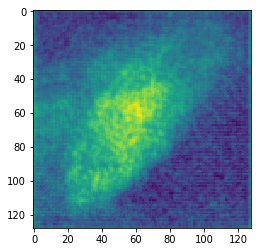

In [4]:
plt.imshow(x_train[1,:,:,7])

In [5]:
def model(x):
    x=layers.Conv2D(filters=32,input_shape=(128,128,12), kernel_size=(3,3),padding='same')(x)
    x=layers.LeakyReLU()(x)
    x=layers.BatchNormalization()(x)
    
    x=layers.Conv2D(filters=16, kernel_size=(3,3),padding='same')(x)
    x=layers.LeakyReLU()(x)
    x=layers.BatchNormalization()(x)
    
    
    x=layers.Conv2D(filters=num_classes, 
                     kernel_size=(3,3),padding='same',activation='softmax')(x)
    
    x=Reshape([-1,2])(x)
    return x
image_tensor = layers.Input(shape=(128,128,12))
network_output = model(image_tensor)    
model = models.Model(inputs=[image_tensor], outputs=[network_output])

model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 12)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      3488      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      4624      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
__________

### Training

In [6]:
batch_size = 10
epochs = 200
def scheduler(epoch):
    if epoch % 50==0 and epoch<800 and epoch >1:
        K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr)*0.1)
    return K.get_value(model.optimizer.lr)

change_lr = LearningRateScheduler(scheduler)
# Run the train
history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=[change_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 20 samples, validate on 10 samples
Epoch 1/1000
20/20 [==============================] - 1s 43ms/step - loss: 0.5508 - acc: 0.7513 - val_loss: 0.4752 - val_acc: 0.8161
Epoch 2/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.4627 - acc: 0.8062 - val_loss: 0.7915 - val_acc: 0.6698
Epoch 3/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.4096 - acc: 0.8370 - val_loss: 0.5991 - val_acc: 0.7656
Epoch 4/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.3839 - acc: 0.8663 - val_loss: 0.4117 - val_acc: 0.8650
Epoch 5/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.3475 - acc: 0.8983 - val_loss: 0.6945 - val_acc: 0.7420
Epoch 6/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.3182 - acc: 0.9113 - val_loss: 0.9501 - val_acc: 0.5778
Epoch 7/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.3004 - acc: 0.9125 - val_loss: 1.7856 - val_acc: 0.3790
Epoch 8/1000
20/20 [===========

20/20 [==============================] - 0s 4ms/step - loss: 0.1024 - acc: 0.9681 - val_loss: 0.2409 - val_acc: 0.9404
Epoch 124/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0955 - acc: 0.9723 - val_loss: 0.2397 - val_acc: 0.9406
Epoch 125/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0933 - acc: 0.9718 - val_loss: 0.2380 - val_acc: 0.9409
Epoch 126/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0953 - acc: 0.9714 - val_loss: 0.2367 - val_acc: 0.9411
Epoch 127/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0984 - acc: 0.9708 - val_loss: 0.2355 - val_acc: 0.9414
Epoch 128/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0947 - acc: 0.9715 - val_loss: 0.2342 - val_acc: 0.9415
Epoch 129/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1051 - acc: 0.9681 - val_loss: 0.2334 - val_acc: 0.9415
Epoch 130/1000
20/20 [==============================] - 0s 4ms/step - loss: 0

20/20 [==============================] - 0s 4ms/step - loss: 0.0932 - acc: 0.9724 - val_loss: 0.1973 - val_acc: 0.9446
Epoch 246/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0948 - acc: 0.9721 - val_loss: 0.1972 - val_acc: 0.9446
Epoch 247/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1068 - acc: 0.9691 - val_loss: 0.1973 - val_acc: 0.9446
Epoch 248/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0934 - acc: 0.9719 - val_loss: 0.1972 - val_acc: 0.9446
Epoch 249/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1072 - acc: 0.9670 - val_loss: 0.1972 - val_acc: 0.9446
Epoch 250/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1043 - acc: 0.9679 - val_loss: 0.1971 - val_acc: 0.9445
Epoch 251/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1052 - acc: 0.9681 - val_loss: 0.1971 - val_acc: 0.9445
Epoch 252/1000
20/20 [==============================] - 0s 4ms/step - loss: 0

20/20 [==============================] - 0s 4ms/step - loss: 0.0949 - acc: 0.9716 - val_loss: 0.1950 - val_acc: 0.9446
Epoch 368/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1007 - acc: 0.9701 - val_loss: 0.1950 - val_acc: 0.9446
Epoch 369/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0918 - acc: 0.9723 - val_loss: 0.1950 - val_acc: 0.9446
Epoch 370/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0923 - acc: 0.9727 - val_loss: 0.1950 - val_acc: 0.9446
Epoch 371/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0954 - acc: 0.9709 - val_loss: 0.1950 - val_acc: 0.9446
Epoch 372/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1071 - acc: 0.9681 - val_loss: 0.1950 - val_acc: 0.9446
Epoch 373/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0903 - acc: 0.9735 - val_loss: 0.1950 - val_acc: 0.9446
Epoch 374/1000
20/20 [==============================] - 0s 4ms/step - loss: 0

20/20 [==============================] - 0s 4ms/step - loss: 0.0920 - acc: 0.9724 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 490/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0985 - acc: 0.9700 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 491/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0937 - acc: 0.9717 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 492/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0929 - acc: 0.9720 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 493/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1209 - acc: 0.9633 - val_loss: 0.1951 - val_acc: 0.9445
Epoch 494/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1173 - acc: 0.9653 - val_loss: 0.1952 - val_acc: 0.9445
Epoch 495/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0985 - acc: 0.9703 - val_loss: 0.1951 - val_acc: 0.9445
Epoch 496/1000
20/20 [==============================] - 0s 4ms/step - loss: 0

20/20 [==============================] - 0s 4ms/step - loss: 0.1038 - acc: 0.9685 - val_loss: 0.1952 - val_acc: 0.9445
Epoch 612/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0962 - acc: 0.9712 - val_loss: 0.1951 - val_acc: 0.9445
Epoch 613/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0932 - acc: 0.9725 - val_loss: 0.1951 - val_acc: 0.9445
Epoch 614/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0986 - acc: 0.9718 - val_loss: 0.1951 - val_acc: 0.9445
Epoch 615/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0949 - acc: 0.9712 - val_loss: 0.1951 - val_acc: 0.9445
Epoch 616/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0999 - acc: 0.9698 - val_loss: 0.1951 - val_acc: 0.9445
Epoch 617/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0917 - acc: 0.9728 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 618/1000
20/20 [==============================] - 0s 4ms/step - loss: 0

20/20 [==============================] - 0s 4ms/step - loss: 0.0973 - acc: 0.9702 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 734/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1008 - acc: 0.9709 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 735/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0923 - acc: 0.9724 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 736/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0936 - acc: 0.9716 - val_loss: 0.1949 - val_acc: 0.9445
Epoch 737/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1071 - acc: 0.9690 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 738/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1040 - acc: 0.9685 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 739/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0938 - acc: 0.9720 - val_loss: 0.1950 - val_acc: 0.9445
Epoch 740/1000
20/20 [==============================] - 0s 4ms/step - loss: 0

20/20 [==============================] - 0s 4ms/step - loss: 0.0996 - acc: 0.9690 - val_loss: 0.1947 - val_acc: 0.9445
Epoch 856/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0968 - acc: 0.9705 - val_loss: 0.1946 - val_acc: 0.9445
Epoch 857/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0941 - acc: 0.9716 - val_loss: 0.1946 - val_acc: 0.9445
Epoch 858/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0998 - acc: 0.9706 - val_loss: 0.1947 - val_acc: 0.9445
Epoch 859/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0953 - acc: 0.9709 - val_loss: 0.1946 - val_acc: 0.9445
Epoch 860/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0999 - acc: 0.9699 - val_loss: 0.1947 - val_acc: 0.9445
Epoch 861/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0930 - acc: 0.9719 - val_loss: 0.1946 - val_acc: 0.9445
Epoch 862/1000
20/20 [==============================] - 0s 4ms/step - loss: 0

20/20 [==============================] - 0s 4ms/step - loss: 0.0930 - acc: 0.9720 - val_loss: 0.1948 - val_acc: 0.9445
Epoch 978/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0916 - acc: 0.9724 - val_loss: 0.1947 - val_acc: 0.9445
Epoch 979/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0921 - acc: 0.9723 - val_loss: 0.1947 - val_acc: 0.9445
Epoch 980/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.1011 - acc: 0.9693 - val_loss: 0.1947 - val_acc: 0.9445
Epoch 981/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0965 - acc: 0.9709 - val_loss: 0.1947 - val_acc: 0.9445
Epoch 982/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0938 - acc: 0.9718 - val_loss: 0.1947 - val_acc: 0.9445
Epoch 983/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0916 - acc: 0.9731 - val_loss: 0.1947 - val_acc: 0.9445
Epoch 984/1000
20/20 [==============================] - 0s 4ms/step - loss: 0

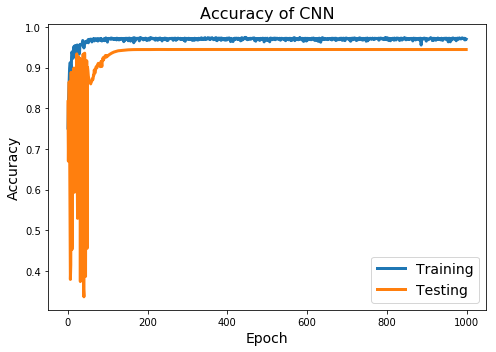

In [7]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of CNN', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

### Choose a picture

In [12]:
no=2

***By random walker***

Gradient conjugué


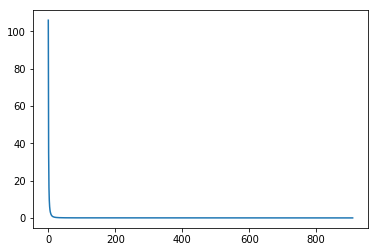

Gradient conjugué


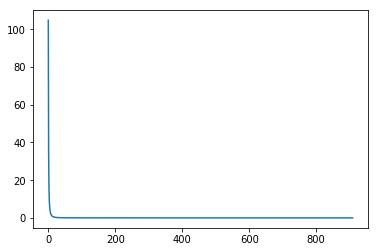

Time to compute the linear system:  1.6247172355651855


In [13]:
test_file=get_filename_list(seg.test_file,seg.config)
la_filename=test_file[0][no]
im = imread(la_filename,pilmode='L')/255
e=EclipseGenerator.Eclipse(1,1,N=128)
#e.img=im
#e.Plot()
#plt.show()
seeds=[[int(len(im[no])/2),int(len(im[no])/2)],[127,127]]
labels=[0,1]
beta=90
[mask,proba]=Random_walker.random_walker(im,seeds,labels,beta)
#e.img=mask
#e.Plot()

**By SegNet_transfer**

datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,fill_mode='nearest')

m=model.predict(x_test)
print(m.shape)
m=m[0,:,1].reshape(1,128,128,1)

datagen.fit(m)
m=model.predict(x_test)
m=m.reshape(10,128,128,2)
m=m[0]
m=datagen.apply_transform(m,{'theta':60})
print(m.shape)
plt.imshow(m[:,:,1])
plt.show()

In [14]:
m=model.predict(x_test)
res=np.argmax(m[no],1)
res=res.reshape(128,128)
#plt.imshow(test_images[no])
#plt.show()
#plt.imshow(res)
#print(res)

Text(0.5, 1.0, 'Random_walker')

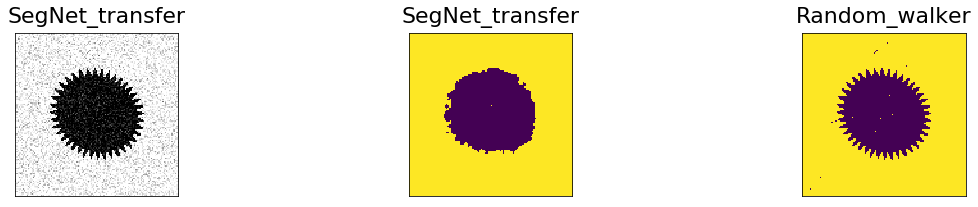

In [15]:
num_images=1
cols=['Raw Image', 'SegNet_transfer', 'Random_walker']
fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(20,num_images*3))
plt.subplot(num_images, 3, 1)
plt.imshow(test_images[no])
plt.xticks([])
plt.yticks([])
plt.title(cols[1], size='22', va='bottom')
plt.subplot(num_images, 3, 2)
plt.imshow(res)
plt.xticks([])
plt.yticks([])
plt.title(cols[1], size='22', va='bottom')
plt.subplot(num_images, 3, 3)
plt.imshow(mask)
plt.xticks([])
plt.yticks([])
plt.title(cols[2], size='22', va='bottom')

## Loss and accuracy
**Random walker**

In [23]:
def loss(x):
    #x=Reshape([-1,2])(x)
    return x
image_tensor = layers.Input(shape=(128*128,2))
network_output = loss(image_tensor)    
loss = models.Model(inputs=[image_tensor], outputs=[network_output])

loss.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
#print(loss.summary())
mask_onehot=np.array([1-mask.reshape([128*128,1]),mask.reshape([128*128,1])]).T

#%%
score = loss.evaluate(mask_onehot, np.array([y_test[no]]), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1920930376163597e-07
Test accuracy: 1.0


**SegNet**

In [24]:
score = model.evaluate(np.array([x_test[no]]), np.array([y_test[no]]), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1488000452518463
Test accuracy: 0.938232421875
